## Install all the needed packages

In [27]:
%matplotlib inline

# DataFrame
import pandas as pd

# Elasticsearch
from elasticsearch import Elasticsearch, helpers

# datetime
from datetime import datetime

# isnan()
import math

# plot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Create the local raw_data_pool (IP address rather than site name)

In [2]:
raw_data_pool = {}

def make_sure(src_site_name, src_site_ip, dest_site_name, dest_site_ip):
    if src_site_ip not in raw_data_pool:
        raw_data_pool[src_site_ip] = {}
        print("In raw_data_pool, created new src_site_ip {} representing src_site_name {}".format(src_site_ip, src_site_name))
    if dest_site_ip not in raw_data_pool[src_site_ip]:
        raw_data_pool[src_site_ip][dest_site_ip] = pd.DataFrame()
        print("In raw_data_pool, created source site {}'s new dest_site_ip {} representing dest_site_name {}".format(src_site_name, dest_site_ip, dest_site_name))

def put_data(src_site_name, src_site_ip, dest_site_name, dest_site_ip, timestamp_epoch, column_type, value):
    make_sure(src_site_name, src_site_ip, dest_site_name, dest_site_ip)
    raw_data_pool[src_site_ip][dest_site_ip].set_value(timestamp_epoch, column_type, value)

## Create the elasticsearch connection

In [9]:
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=6000)

## Generate the common part of the queries

In [4]:
src_site_name = 'source_site_name'
dest_site_name = 'destination_site_name'
# src_site_ip = 'source_site_ip'
# dest_site_ip = 'destination_site_ip'

timestamp = { 'gte': '2016-01-01', 'lt': '2016-06-01' }

my_query = {}
my_query['query'] = {}
my_query['query']['filtered'] = {}
my_query['query']['filtered']['query'] = { "match_all": {} }
my_query['query']['filtered']['filter'] = {}
my_query['query']['filtered']['filter']['bool'] = {}
my_query['query']['filtered']['filter']['bool']['must'] = []
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'srcSite': src_site_name } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'destSite': dest_site_name } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'range': { 'timestamp': timestamp } })
my_query['fielddata_fields'] = [ 'timestamp' ]

print(my_query)

my_index = "network_weather_2-*"

print(my_index)

{'fielddata_fields': ['timestamp'], 'query': {'filtered': {'filter': {'bool': {'must': [{'term': {'srcSite': 'source_site_name'}}, {'term': {'destSite': 'destination_site_name'}}, {'range': {'timestamp': {'gte': '2016-01-01', 'lt': '2016-06-01'}}}]}}, 'query': {'match_all': {}}}}}
network_weather_2-*


## Define the function to collect and clean the raw data for a given src/dest pair

In [5]:
def collect_and_clean(src_site_name, dest_site_name):
    
    set_src = set()
    set_dest = set()
    
    # Set the source/destination pair
    my_query['query']['filtered']['filter']['bool']['must'][0]['term']['srcSite'] = src_site_name
    my_query['query']['filtered']['filter']['bool']['must'][1]['term']['destSite'] = dest_site_name
    print(my_query)
    print()
    
    # Collect latency raw data
    my_type = 'latency'
    scroll = list(helpers.scan(client=es, query=my_query, index=my_index, doc_type=my_type, request_timeout=6000))
    count = 0
    for result in scroll:
        count += 1
        timestamp_epoch = result['fields']['timestamp'][0]
        set_src.add(result['_source']['src'])
        set_dest.add(result['_source']['dest'])
        put_data(src_site_name, result['_source']['src'], dest_site_name, result['_source']['dest'], timestamp_epoch, 'iso_8601', result['_source']['timestamp'])
        put_data(src_site_name, result['_source']['src'], dest_site_name, result['_source']['dest'], timestamp_epoch, 'delay_median', result['_source']['delay_median'])
        put_data(src_site_name, result['_source']['src'], dest_site_name, result['_source']['dest'], timestamp_epoch, 'delay_mean', result['_source']['delay_mean'])
        put_data(src_site_name, result['_source']['src'], dest_site_name, result['_source']['dest'], timestamp_epoch, 'delay_sd', result['_source']['delay_sd'])
    print('Number of raw records of {} is {}'.format(my_type, count))
    
    # Collect packet_loss_rate raw data
    my_type = 'packet_loss_rate'
    scroll = list(helpers.scan(client=es, query=my_query, index=my_index, doc_type=my_type, request_timeout=6000))
    count = 0
    for result in scroll:
        count += 1
        timestamp_epoch = result['fields']['timestamp'][0]
        set_src.add(result['_source']['src'])
        set_dest.add(result['_source']['dest'])
        put_data(src_site_name, result['_source']['src'], dest_site_name, result['_source']['dest'], timestamp_epoch, 'iso_8601', result['_source']['timestamp'])
        put_data(src_site_name, result['_source']['src'], dest_site_name, result['_source']['dest'], timestamp_epoch, 'packet_loss', result['_source']['packet_loss'])
    print('Number of raw records of {} is {}'.format(my_type, count))
    
    # Collect throughput raw data
    my_type = 'throughput'
    scroll = list(helpers.scan(client=es, query=my_query, index=my_index, doc_type=my_type, request_timeout=6000))
    count = 0
    for result in scroll:
        count += 1
        timestamp_epoch = result['fields']['timestamp'][0]
        set_src.add(result['_source']['src'])
        set_dest.add(result['_source']['dest'])
        put_data(src_site_name, result['_source']['src'], dest_site_name, result['_source']['dest'], timestamp_epoch, 'iso_8601', result['_source']['timestamp'])
        put_data(src_site_name, result['_source']['src'], dest_site_name, result['_source']['dest'], timestamp_epoch, 'throughput', result['_source']['throughput'])
    print('Number of raw records of {} is {}'.format(my_type, count))
    
    print()
    for s in set_src:
        print('src_site_name {} has src_site_ip {}'.format(src_site_name, s))
    for s in set_dest:
        print('dest_site_name {} has dest_site_ip {}'.format(dest_site_name, s))
    print('Please manually count(), sort_index(), to_pickle() using src_site_ip and dest_site_ip !!!!!!')
    
#     # View statistics of raw_data_pool (already de-duplicated)
#     print()
#     print('De-duplication result:')
#     print(raw_data_pool[src_site][dest_site].count(axis='index'))
    
#     # Sort in-place
#     raw_data_pool[src_site][dest_site].sort_index(inplace=True)
    
#     # Store this DataFrame to disk file
#     raw_data_pool[src_site][dest_site].to_pickle('My_data/My_data_from_{}_to_{}_sorted.pkl'.format(src_site, dest_site))
    
#     # How to get this DataFrame
#     # raw_data_pool[src_site][dest_site]


print('Successfully defined the collect_and_clean(src_site_name, dest_site_name) function')

Successfully defined the collect_and_clean(src_site_name, dest_site_name) function


## Collect and clean raw data

In [6]:
sites = ['MWT2', 'SFU-LCG2', 'CERN-PROD', 'BEIJING-LCG2']

count = 0
for src_site_name in sites:
    for dest_site_name in sites:
        if src_site_name != dest_site_name:
            count += 1
            print('=============================================================================')
            print('{}. Now the pair is {} / {}'.format(count, src_site_name, dest_site_name))
            print()
            collect_and_clean(src_site_name, dest_site_name)
            print('=============================================================================')

1. Now the pair is MWT2 / SFU-LCG2

{'fielddata_fields': ['timestamp'], 'query': {'filtered': {'filter': {'bool': {'must': [{'term': {'srcSite': 'MWT2'}}, {'term': {'destSite': 'SFU-LCG2'}}, {'range': {'timestamp': {'gte': '2016-01-01', 'lt': '2016-06-01'}}}]}}, 'query': {'match_all': {}}}}}

In raw_data_pool, created new src_site_ip 149.165.225.223 representing src_site_name MWT2
In raw_data_pool, created source site MWT2's new dest_site_ip 206.12.24.251 representing dest_site_name SFU-LCG2
In raw_data_pool, created new src_site_ip 72.36.96.4 representing src_site_name MWT2
In raw_data_pool, created source site MWT2's new dest_site_ip 206.12.24.251 representing dest_site_name SFU-LCG2
In raw_data_pool, created new src_site_ip 192.170.227.160 representing src_site_name MWT2
In raw_data_pool, created source site MWT2's new dest_site_ip 206.12.24.251 representing dest_site_name SFU-LCG2
Number of raw records of latency is 115191
Number of raw records of packet_loss_rate is 118461
In raw_

In [7]:
raw_data_pool

{'128.142.223.246': {'149.165.225.224':                           iso_8601    throughput
  1456285231000  2016-02-24T03:40:31  9.129630e+08
  1460853980000  2016-04-17T00:46:20  8.182870e+08
  1460940009000  2016-04-18T00:40:09  1.608220e+09
  1461143692000  2016-04-20T09:14:52  1.464250e+09
  1460217344000  2016-04-09T15:55:44  3.493490e+08
  1463057108000  2016-05-12T12:45:08  1.039980e+09
  1464241270000  2016-05-26T05:41:10  1.596510e+09
  1462610270000  2016-05-07T08:37:50  8.814660e+08
  1452151757000  2016-01-07T07:29:17  7.291940e+08
  1452252440000  2016-01-08T11:27:20  9.128810e+08
  1455783175000  2016-02-18T08:12:55  6.698000e+08
  1454978129000  2016-02-09T00:35:29  3.636620e+08
  1461430814000  2016-04-23T17:00:14  4.601050e+08
  1460101039000  2016-04-08T07:37:19  4.489160e+07
  1463939093000  2016-05-22T17:44:53  1.339520e+09
  1452593756000  2016-01-12T10:15:56  8.446720e+08
  1451743639000  2016-01-02T14:07:19  9.063700e+08
  1455946268000  2016-02-20T05:31:08  8.2564

In [8]:
sites = ['MWT2', 'SFU-LCG2', 'CERN-PROD', 'BEIJING-LCG2']

count = 0
for src_site_name in sites:
    for dest_site_name in sites:
        if src_site_name == dest_site_name:
            count += 1
            print('=============================================================================')
            print('{}. Now the pair is {} / {}'.format(count, src_site_name, dest_site_name))
            print()
            collect_and_clean(src_site_name, dest_site_name)
            print('=============================================================================')

1. Now the pair is MWT2 / MWT2

{'fielddata_fields': ['timestamp'], 'query': {'filtered': {'filter': {'bool': {'must': [{'term': {'srcSite': 'MWT2'}}, {'term': {'destSite': 'MWT2'}}, {'range': {'timestamp': {'gte': '2016-01-01', 'lt': '2016-06-01'}}}]}}, 'query': {'match_all': {}}}}}

In raw_data_pool, created source site MWT2's new dest_site_ip 72.36.96.4 representing dest_site_name MWT2
In raw_data_pool, created source site MWT2's new dest_site_ip 192.170.227.160 representing dest_site_name MWT2
In raw_data_pool, created source site MWT2's new dest_site_ip 149.165.225.223 representing dest_site_name MWT2
In raw_data_pool, created source site MWT2's new dest_site_ip 192.170.227.160 representing dest_site_name MWT2
In raw_data_pool, created source site MWT2's new dest_site_ip 149.165.225.223 representing dest_site_name MWT2
In raw_data_pool, created source site MWT2's new dest_site_ip 72.36.96.4 representing dest_site_name MWT2
Number of raw records of latency is 792389
Number of raw r

In [10]:
sites = ['MWT2', 'SFU-LCG2', 'CERN-PROD', 'BEIJING-LCG2']
sites2 = ['Australia-ATLAS']

count = 0
for src_site_name in sites2:
    for dest_site_name in sites:
        if src_site_name != dest_site_name:
            count += 1
            print('=============================================================================')
            print('{}. Now the pair is {} / {}'.format(count, src_site_name, dest_site_name))
            print()
            collect_and_clean(src_site_name, dest_site_name)
            print('=============================================================================')


print()
print()
print()
print()
print()
print()
print()
print()
print()


count = 0
for src_site_name in sites:
    for dest_site_name in sites2:
        if src_site_name != dest_site_name:
            count += 1
            print('=============================================================================')
            print('{}. Now the pair is {} / {}'.format(count, src_site_name, dest_site_name))
            print()
            collect_and_clean(src_site_name, dest_site_name)
            print('=============================================================================')

1. Now the pair is Australia-ATLAS / MWT2

{'fielddata_fields': ['timestamp'], 'query': {'filtered': {'filter': {'bool': {'must': [{'term': {'srcSite': 'Australia-ATLAS'}}, {'term': {'destSite': 'MWT2'}}, {'range': {'timestamp': {'gte': '2016-01-01', 'lt': '2016-06-01'}}}]}}, 'query': {'match_all': {}}}}}

In raw_data_pool, created new src_site_ip 192.231.127.41 representing src_site_name Australia-ATLAS
In raw_data_pool, created source site Australia-ATLAS's new dest_site_ip 192.170.227.160 representing dest_site_name MWT2
In raw_data_pool, created source site Australia-ATLAS's new dest_site_ip 149.165.225.223 representing dest_site_name MWT2
In raw_data_pool, created source site Australia-ATLAS's new dest_site_ip 72.36.96.4 representing dest_site_name MWT2
Number of raw records of latency is 130142
Number of raw records of packet_loss_rate is 137743
In raw_data_pool, created new src_site_ip 192.231.127.40 representing src_site_name Australia-ATLAS
In raw_data_pool, created source sit

In [15]:
count = 0
for src_site_ip in raw_data_pool.keys():
    for dest_site_ip in raw_data_pool[src_site_ip].keys():
        count += 1
        print('{}.  {} -> {}'.format(count, src_site_ip, dest_site_ip))

1.  202.122.32.170 -> 192.231.127.41
2.  202.122.32.170 -> 149.165.225.223
3.  202.122.32.170 -> 192.231.127.40
4.  202.122.32.170 -> 192.170.227.160
5.  202.122.32.170 -> 72.36.96.4
6.  202.122.32.170 -> 206.12.24.251
7.  202.122.32.170 -> 128.142.223.247
8.  149.165.225.223 -> 202.122.32.170
9.  149.165.225.223 -> 192.231.127.41
10.  149.165.225.223 -> 72.36.96.4
11.  149.165.225.223 -> 128.142.223.247
12.  149.165.225.223 -> 192.170.227.160
13.  149.165.225.223 -> 206.12.24.251
14.  206.12.24.250 -> 128.142.223.246
15.  206.12.24.250 -> 202.122.32.166
16.  206.12.24.250 -> 192.170.227.162
17.  206.12.24.250 -> 192.231.127.40
18.  206.12.24.250 -> 72.36.96.9
19.  206.12.24.250 -> 149.165.225.224
20.  192.170.227.162 -> 128.142.223.246
21.  192.170.227.162 -> 202.122.32.166
22.  192.170.227.162 -> 206.12.24.250
23.  192.170.227.162 -> 192.231.127.40
24.  192.170.227.162 -> 72.36.96.9
25.  192.170.227.162 -> 149.165.225.224
26.  192.231.127.41 -> 202.122.32.170
27.  192.231.127.41 -> 1

In [14]:
count = 0
for src_site_ip in raw_data_pool.keys():
    for dest_site_ip in raw_data_pool[src_site_ip].keys():
        count += 1
        print('{}.  {} -> {}'.format(count, src_site_ip, dest_site_ip))
        
        # View statistics of raw_data_pool (already de-duplicated)
        print()
        print('De-duplication result:')
        print(raw_data_pool[src_site_ip][dest_site_ip].count(axis='index'))
    
        # Sort in-place
        raw_data_pool[src_site_ip][dest_site_ip].sort_index(inplace=True)
    
        # Store this DataFrame to disk file
        raw_data_pool[src_site_ip][dest_site_ip].to_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_site_ip, dest_site_ip))
    
        # How to get this DataFrame
        # raw_data_pool[src_site][dest_site]
        
        print()
        print()
        print()

1.  202.122.32.170 -> 192.231.127.41

De-duplication result:
iso_8601        3731
delay_median    3627
delay_mean      3627
delay_sd        3627
packet_loss     3705
dtype: int64



2.  202.122.32.170 -> 149.165.225.223

De-duplication result:
iso_8601        4425
delay_median    4294
delay_mean      4294
delay_sd        4294
packet_loss     4391
dtype: int64



3.  202.122.32.170 -> 192.231.127.40

De-duplication result:
iso_8601        1208
delay_median    1162
delay_mean      1162
delay_sd        1162
packet_loss     1198
dtype: int64



4.  202.122.32.170 -> 192.170.227.160

De-duplication result:
iso_8601        4218
delay_median    4090
delay_mean      4090
delay_sd        4090
packet_loss     4179
dtype: int64



5.  202.122.32.170 -> 72.36.96.4

De-duplication result:
iso_8601        4749
delay_median    4611
delay_mean      4611
delay_sd        4611
packet_loss     4718
dtype: int64



6.  202.122.32.170 -> 206.12.24.251

De-duplication result:
iso_8601        5030
delay_media

## Begin to play with the clean data

In [20]:
src_site_ip = '192.231.127.41'    # Australia-ATLAS 192.231.127.40
dest_site_ip = '202.122.32.170'   # BEIJING-LCG2 202.122.32.166

data_41_170 = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_site_ip, dest_site_ip))

data_41_170

,iso_8601,delay_median,delay_mean,delay_sd,packet_loss
1451607000000,2016-01-01T00:10:00,78.50,78.506000,0.053516,0.000000
1451609400000,2016-01-01T00:50:00,76.70,76.699722,0.071840,0.000000
1451611800000,2016-01-01T01:30:00,78.20,78.162000,0.070399,0.000000
1451613900000,2016-01-01T02:05:00,79.60,79.614867,0.140377,0.000000
1451616600000,2016-01-01T02:50:00,81.50,81.489833,0.053041,0.000000
1451619000000,2016-01-01T03:30:00,80.10,80.117333,0.049661,0.000000
1451621100000,2016-01-01T04:05:00,79.40,79.398000,0.039531,0.000000
1451623200000,2016-01-01T04:40:00,77.70,77.765542,0.134753,0.000000
1451625600000,2016-01-01T05:20:00,77.60,77.611833,0.050761,0.000000
1451627700000,2016-01-01T05:55:00,77.50,77.613333,0.332900,0.000000


In [21]:
src_site_ip = '192.231.127.40'    # Australia-ATLAS 192.231.127.41
dest_site_ip = '202.122.32.170'   # BEIJING-LCG2 202.122.32.166

data_40_170 = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_site_ip, dest_site_ip))

data_40_170

,iso_8601,delay_median,delay_mean,delay_sd,packet_loss
1451606400000,2016-01-01T00:00:00,78.7,78.704056,0.053543,0.000
1451608800000,2016-01-01T00:40:00,78.3,78.375208,0.142850,0.000
1451611500000,2016-01-01T01:25:00,78.4,78.532000,1.244686,0.000
1451614200000,2016-01-01T02:10:00,79.8,79.816500,0.045947,0.000
1451616600000,2016-01-01T02:50:00,81.7,81.691778,0.053220,0.000
1451619300000,2016-01-01T03:35:00,77.5,77.542500,0.052381,0.000
1451621700000,2016-01-01T04:15:00,84.9,84.911833,0.038427,0.000
1451624100000,2016-01-01T04:55:00,78.6,80.934833,2.855177,0.000
1451626800000,2016-01-01T05:40:00,78.0,78.054389,0.138093,0.000
1451629200000,2016-01-01T06:20:00,77.7,77.661708,0.062487,0.000


In [22]:
src_site_ip = '192.231.127.40'    # Australia-ATLAS 192.231.127.41
dest_site_ip = '202.122.32.166'   # BEIJING-LCG2 202.122.32.170

data_40_166 = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_site_ip, dest_site_ip))

data_40_166

,iso_8601,throughput
1451610134000,2016-01-01T01:02:14,279726000.0
1451624619000,2016-01-01T05:03:39,410438000.0
1451639999000,2016-01-01T09:19:59,409581000.0
1451654042000,2016-01-01T13:14:02,416338000.0
1451667128000,2016-01-01T16:52:08,294559000.0
1451669488000,2016-01-01T17:31:28,420664000.0
1451683162000,2016-01-01T21:19:22,424117000.0
1451697520000,2016-01-02T01:18:40,374679000.0
1451712207000,2016-01-02T05:23:27,388847000.0
1451727544000,2016-01-02T09:39:04,397071000.0


In [25]:
print(data_41_170.count(axis='index'))   # normal, both are latency / packet loss servers
print()
print(data_40_170.count(axis='index'))   # abnormal, australia uses its throughput server to do latency / packet loss
print()
print(data_40_166.count(axis='index'))   # normal, both are throughput servers

iso_8601        3868
delay_median    3752
delay_mean      3752
delay_sd        3752
packet_loss     3836
dtype: int64

iso_8601        3627
delay_median    3523
delay_mean      3523
delay_sd        3523
packet_loss     3601
dtype: int64

iso_8601      752
throughput    752
dtype: int64


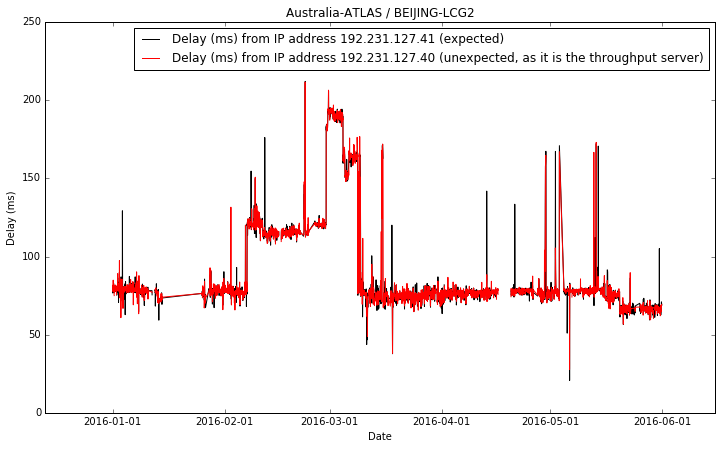

In [44]:
plt.figure(figsize=[12, 7])
plt.plot(data_41_170.index, data_41_170.delay_median, c='k', label='Delay (ms) from IP address 192.231.127.41 (expected)')
plt.plot(data_40_170.index, data_40_170.delay_median, c='r', label='Delay (ms) from IP address 192.231.127.40 (unexpected, as it is the throughput server)')
plt.legend()


x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']
plt.xticks(x, lbl, rotation=0)

plt.xlabel('Date')
plt.ylabel('Delay (ms)')
plt.title('{} / {}'.format('Australia-ATLAS', 'BEIJING-LCG2'))
plt.show()


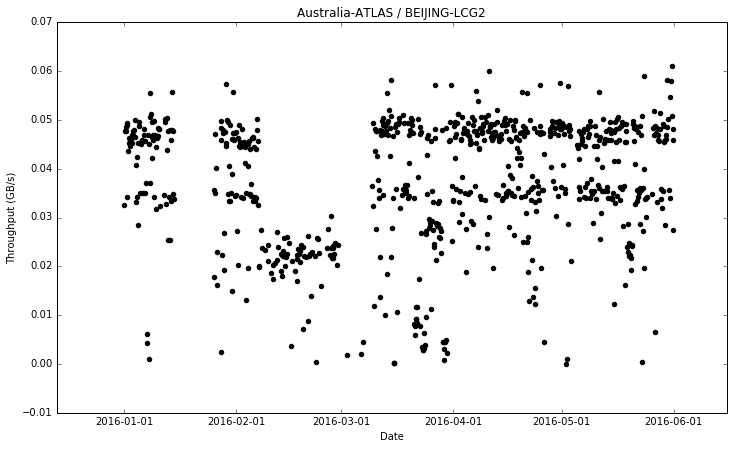

In [49]:
plt.figure(figsize=[12, 7])
plt.scatter(data_40_166.index, data_40_166.throughput / 1024 / 1024 / 1024 / 8, c='k')
# plt.plot(data_40_170.index, data_40_170.delay_median, c='r', label='Delay (ms) from IP address 192.231.127.40 (unexpected, as it is the throughput server)')
# plt.legend()


x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']
plt.xticks(x, lbl, rotation=0)

plt.xlabel('Date')
plt.ylabel('Throughput (GB/s)')
plt.title('{} / {}'.format('Australia-ATLAS', 'BEIJING-LCG2'))
plt.show()


In [50]:
src_site_ip = '202.122.32.170'   # BEIJING-LCG2 202.122.32.166
dest_site_ip = '192.231.127.41'    # Australia-ATLAS 192.231.127.40

data_170_41 = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_site_ip, dest_site_ip))

data_170_41

,iso_8601,delay_median,delay_mean,delay_sd,packet_loss
1451606400000,2016-01-01T00:00:00,76.7,76.710167,0.033862,0.000000
1451608800000,2016-01-01T00:40:00,78.6,78.560917,0.050141,0.000000
1451611200000,2016-01-01T01:20:00,77.1,77.061083,0.051256,0.000000
1451613900000,2016-01-01T02:05:00,75.7,75.696833,0.046079,0.000000
1451616600000,2016-01-01T02:50:00,73.7,73.747944,0.054734,0.000000
1451619000000,2016-01-01T03:30:00,75.4,75.354111,0.075017,0.000000
1451621400000,2016-01-01T04:10:00,75.8,75.804300,0.038792,0.000000
1451624100000,2016-01-01T04:55:00,77.6,77.603722,0.038478,0.000000
1451626800000,2016-01-01T05:40:00,77.7,77.715333,0.050315,0.000000
1451629200000,2016-01-01T06:20:00,75.1,75.103750,0.275701,0.000000


In [52]:
src_site_ip = '202.122.32.170'   # BEIJING-LCG2 202.122.32.166
dest_site_ip = '192.231.127.40'    # Australia-ATLAS 192.231.127.41

data_170_40 = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_site_ip, dest_site_ip))

data_170_40

,iso_8601,delay_median,delay_mean,delay_sd,packet_loss
1451624700000,2016-01-01T05:05:00,77.60,81.023500,9.153713,0.000000
1451629800000,2016-01-01T06:30:00,77.30,77.324167,0.043581,0.000000
1451634900000,2016-01-01T07:55:00,74.50,74.492333,0.041728,0.000000
1451698200000,2016-01-02T01:30:00,75.50,75.511708,0.037422,0.000000
1451700900000,2016-01-02T02:15:00,79.60,79.604056,0.025824,0.000000
1451703600000,2016-01-02T03:00:00,78.90,78.920167,0.040124,0.000000
1451706000000,2016-01-02T03:40:00,77.80,77.807542,0.030642,0.000000
1451708400000,2016-01-02T04:20:00,77.30,82.803143,17.950720,0.027778
1451710800000,2016-01-02T05:00:00,75.60,81.618267,12.573861,0.000000
1451713200000,2016-01-02T05:40:00,77.40,77.397667,0.035041,0.000000


In [53]:
src_site_ip = '202.122.32.166'   # BEIJING-LCG2 202.122.32.170
dest_site_ip = '192.231.127.40'    # Australia-ATLAS 192.231.127.41

data_166_40 = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_site_ip, dest_site_ip))

data_166_40

,iso_8601,throughput
1451609045000,2016-01-01T00:44:05,311338000.0
1451623785000,2016-01-01T04:49:45,531897000.0
1451638058000,2016-01-01T08:47:38,326547000.0
1451652370000,2016-01-01T12:46:10,532027000.0
1451666214000,2016-01-01T16:36:54,327793000.0
1451669289000,2016-01-01T17:28:09,326352000.0
1451682525000,2016-01-01T21:08:45,535483000.0
1451697045000,2016-01-02T01:10:45,319374000.0
1451710877000,2016-01-02T05:01:17,144283000.0
1451725506000,2016-01-02T09:05:06,329856000.0


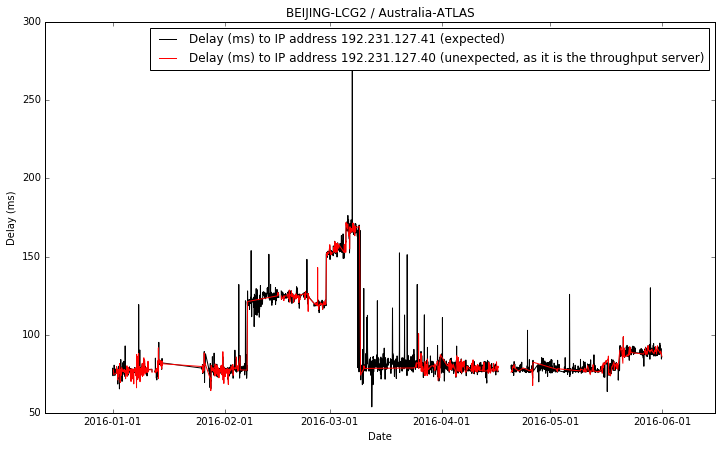

In [54]:
plt.figure(figsize=[12, 7])
plt.plot(data_170_41.index, data_170_41.delay_median, c='k', label='Delay (ms) to IP address 192.231.127.41 (expected)')
plt.plot(data_170_40.index, data_170_40.delay_median, c='r', label='Delay (ms) to IP address 192.231.127.40 (unexpected, as it is the throughput server)')
plt.legend()


x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']
plt.xticks(x, lbl, rotation=0)

plt.xlabel('Date')
plt.ylabel('Delay (ms)')
plt.title('{} / {}'.format('BEIJING-LCG2', 'Australia-ATLAS'))
plt.show()

## Start to analyze the six sites

In [58]:
name_list = ['MWT2_a', 'MWT2_b', 'MWT2_c', 'SFU', 'CERN', 'BEIJING']
ip_list_lpl = ['192.170.227.160', '149.165.225.223', '72.36.96.4', '206.12.24.251', '128.142.223.247', '202.122.32.170']
ip_list_t = ['192.170.227.162', '149.165.225.224', '72.36.96.9', '206.12.24.250', '128.142.223.246', '202.122.32.166']

count = 0
for src_site_ip in ip_list_lpl:
    for dest_site_ip in ip_list_lpl:
        if src_site_ip != dest_site_ip:
            count += 1
            print('{}.  {} -> {}'.format(count, src_site_ip, dest_site_ip))
            data = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_site_ip, dest_site_ip))
            print()
            print(data.count(axis='index'))
            print()

1.  192.170.227.160 -> 149.165.225.223

iso_8601        15520
delay_median    15149
delay_mean      15149
delay_sd        15149
packet_loss     15515
dtype: int64

2.  192.170.227.160 -> 72.36.96.4

iso_8601        16406
delay_median    16048
delay_mean      16048
delay_sd        16048
packet_loss     16389
dtype: int64

3.  192.170.227.160 -> 206.12.24.251

iso_8601        5190
delay_median    5090
delay_mean      5090
delay_sd        5090
packet_loss     5185
dtype: int64

4.  192.170.227.160 -> 128.142.223.247

iso_8601        6534
delay_median    6391
delay_mean      6391
delay_sd        6391
packet_loss     6530
dtype: int64

5.  192.170.227.160 -> 202.122.32.170

iso_8601        5102
delay_median    5002
delay_mean      5002
delay_sd        5002
packet_loss     5096
dtype: int64

6.  149.165.225.223 -> 192.170.227.160

iso_8601        16295
delay_median    15858
delay_mean      15858
delay_sd        15858
packet_loss     16286
dtype: int64

7.  149.165.225.223 -> 72.36.96.4

iso_

In [59]:
name_list = ['MWT2_a', 'MWT2_b', 'MWT2_c', 'SFU', 'CERN', 'BEIJING']
ip_list_lpl = ['192.170.227.160', '149.165.225.223', '72.36.96.4', '206.12.24.251', '128.142.223.247', '202.122.32.170']
ip_list_t = ['192.170.227.162', '149.165.225.224', '72.36.96.9', '206.12.24.250', '128.142.223.246', '202.122.32.166']

count = 0
for src_site_ip in ip_list_t:
    for dest_site_ip in ip_list_t:
        if src_site_ip != dest_site_ip:
            count += 1
            print('{}.  {} -> {}'.format(count, src_site_ip, dest_site_ip))
            data = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_site_ip, dest_site_ip))
            print()
            print(data.count(axis='index'))
            print()

1.  192.170.227.162 -> 149.165.225.224

iso_8601      2862
throughput    2862
dtype: int64

2.  192.170.227.162 -> 72.36.96.9

iso_8601      2895
throughput    2895
dtype: int64

3.  192.170.227.162 -> 206.12.24.250

iso_8601      33
throughput    33
dtype: int64

4.  192.170.227.162 -> 128.142.223.246

iso_8601      44
throughput    44
dtype: int64

5.  192.170.227.162 -> 202.122.32.166

iso_8601      42
throughput    42
dtype: int64

6.  149.165.225.224 -> 192.170.227.162

iso_8601      2838
throughput    2838
dtype: int64

7.  149.165.225.224 -> 72.36.96.9

iso_8601      2872
throughput    2872
dtype: int64

8.  149.165.225.224 -> 206.12.24.250

iso_8601      31
throughput    31
dtype: int64

9.  149.165.225.224 -> 128.142.223.246

iso_8601      37
throughput    37
dtype: int64

10.  149.165.225.224 -> 202.122.32.166

iso_8601      49
throughput    49
dtype: int64

11.  72.36.96.9 -> 192.170.227.162

iso_8601      2887
throughput    2887
dtype: int64

12.  72.36.96.9 -> 149.165.225.

## Begin to draw delay, packet_loss, and throughput time series plots

In [61]:
name_list = ['MWT2_a', 'MWT2_b', 'MWT2_c', 'SFU', 'CERN', 'BEIJING']
for i in range(6):
    print(i)
    print(name_list[i])

0
MWT2_a
1
MWT2_b
2
MWT2_c
3
SFU
4
CERN
5
BEIJING


1.  MWT2_a -> MWT2_b


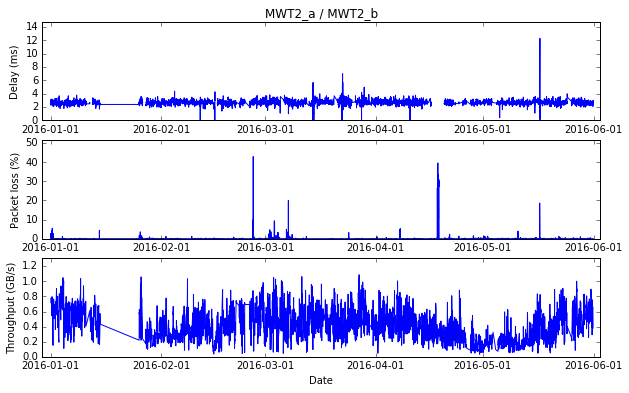

2.  MWT2_a -> MWT2_c


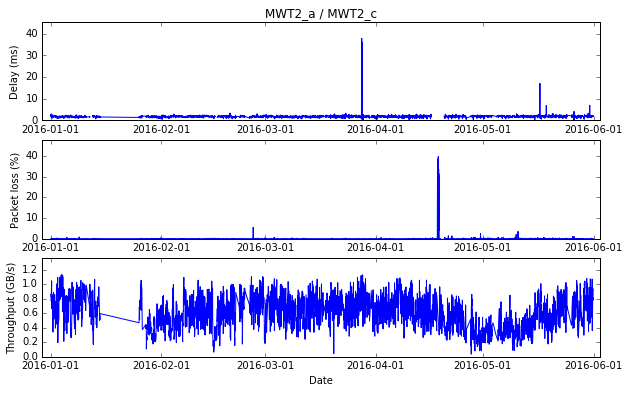

3.  MWT2_a -> SFU


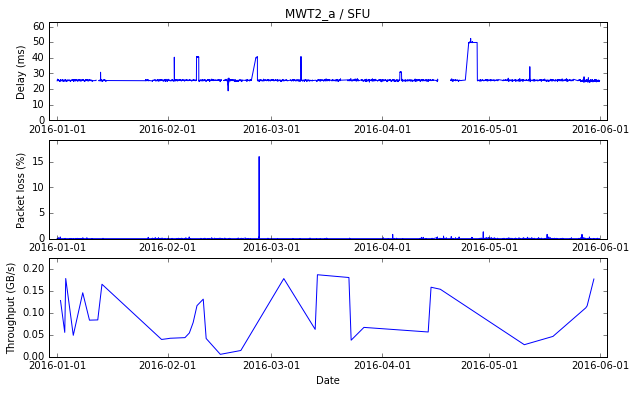

4.  MWT2_a -> CERN


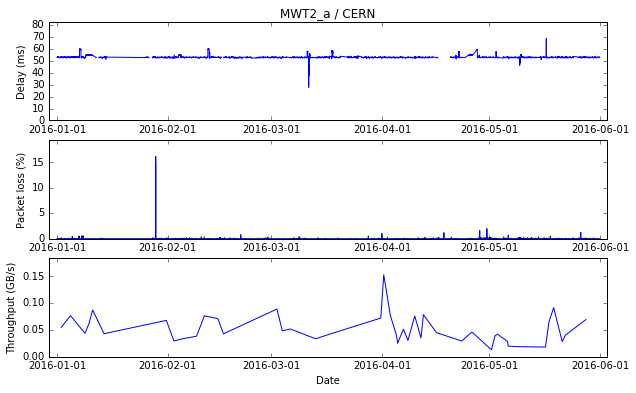

5.  MWT2_a -> BEIJING


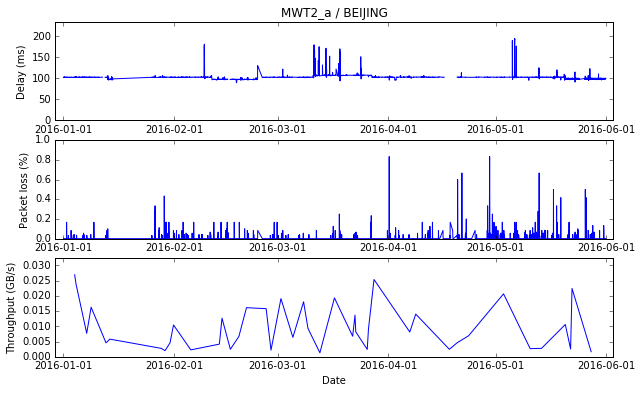

6.  MWT2_b -> MWT2_a


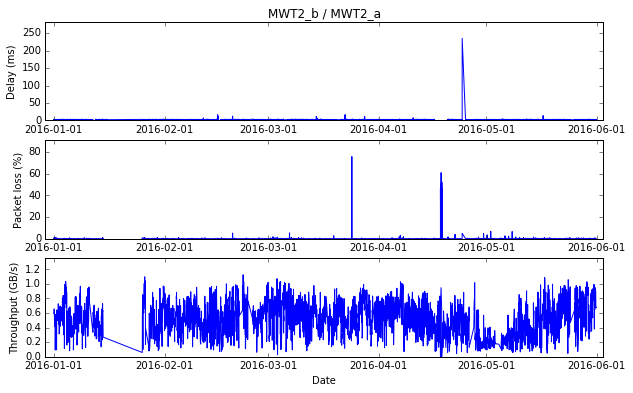

7.  MWT2_b -> MWT2_c


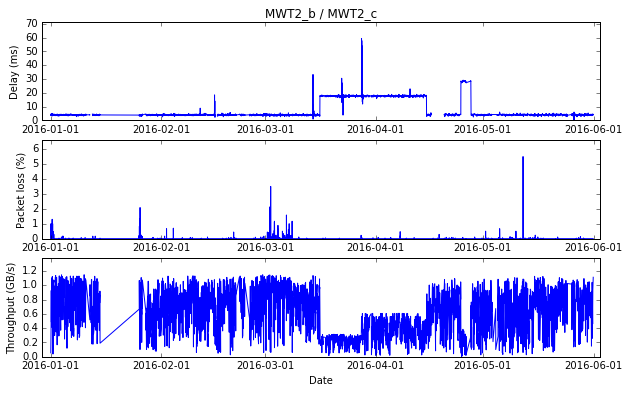

8.  MWT2_b -> SFU


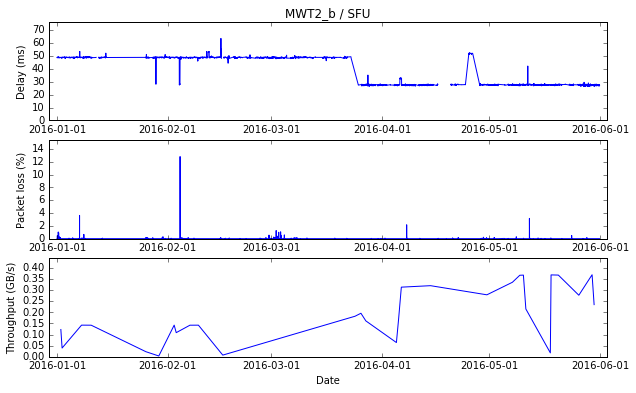

9.  MWT2_b -> CERN


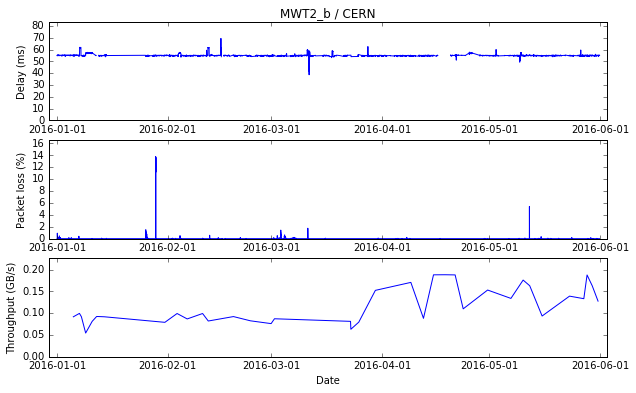

10.  MWT2_b -> BEIJING


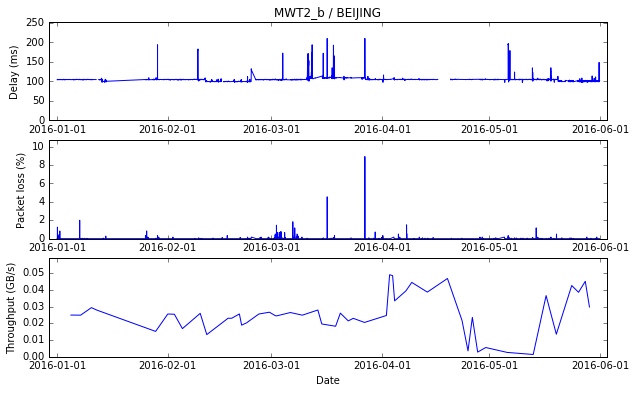

11.  MWT2_c -> MWT2_a


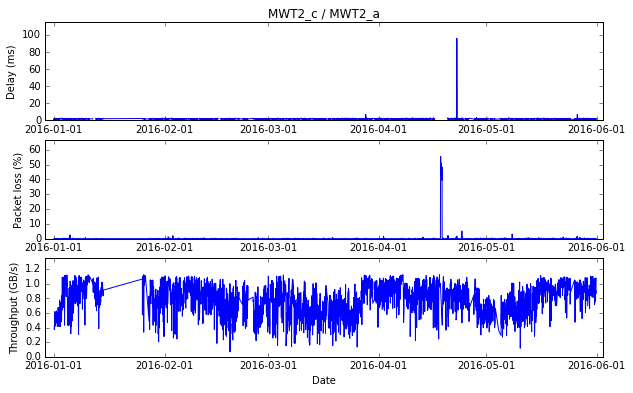

12.  MWT2_c -> MWT2_b


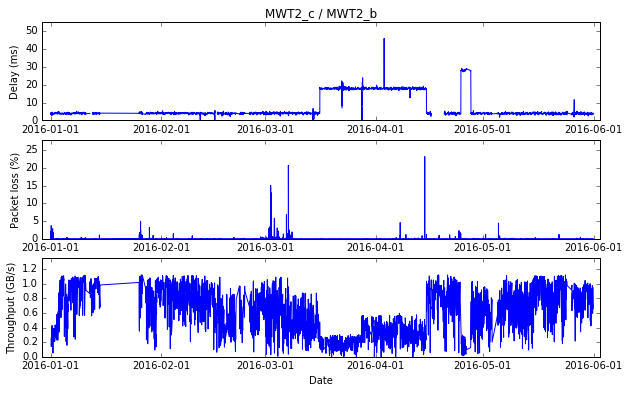

13.  MWT2_c -> SFU


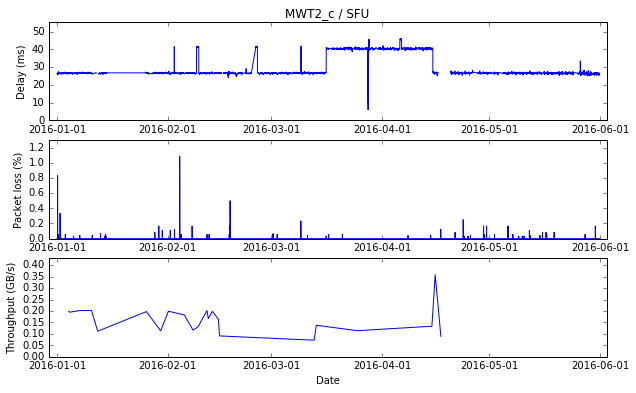

14.  MWT2_c -> CERN


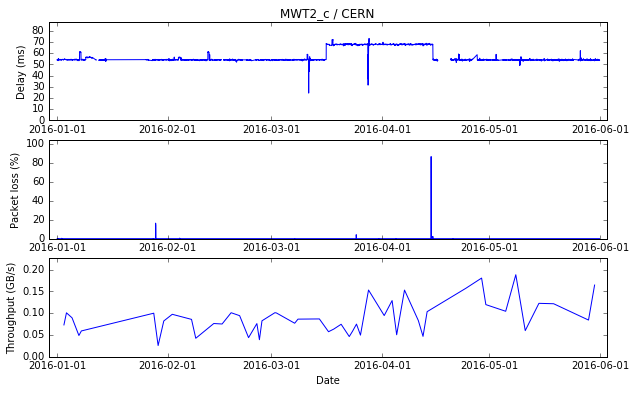

15.  MWT2_c -> BEIJING


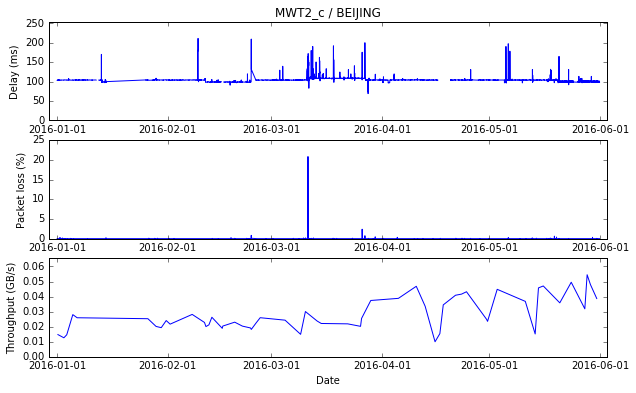

16.  SFU -> MWT2_a


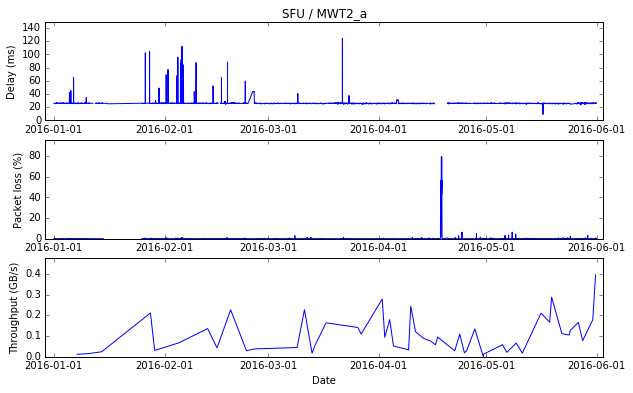

17.  SFU -> MWT2_b


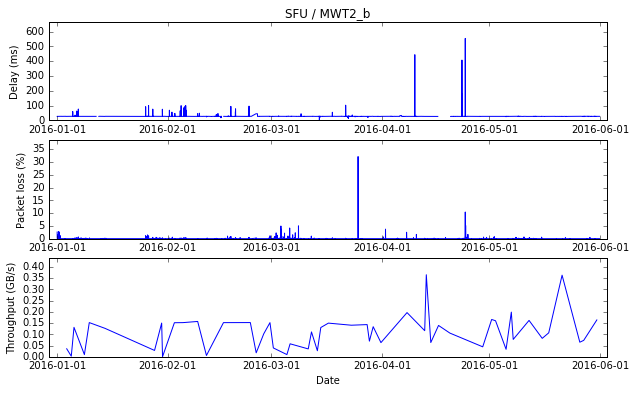

18.  SFU -> MWT2_c


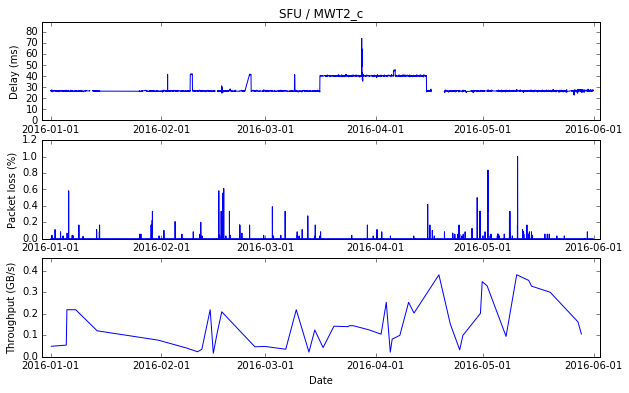

19.  SFU -> CERN


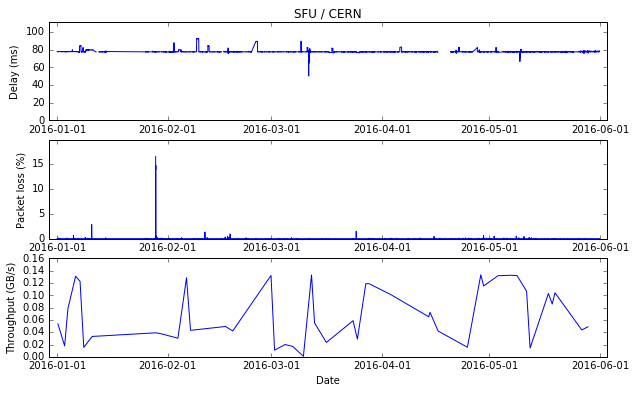

20.  SFU -> BEIJING


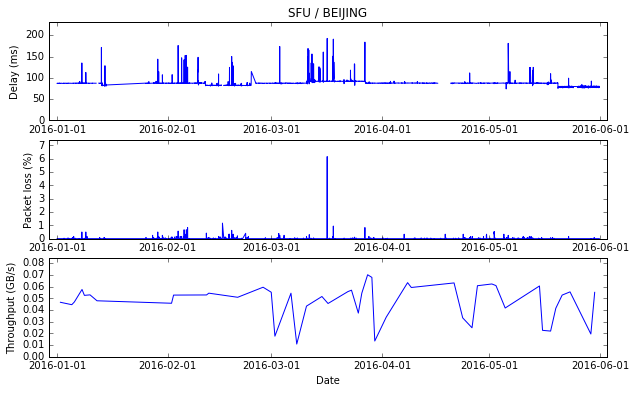

21.  CERN -> MWT2_a


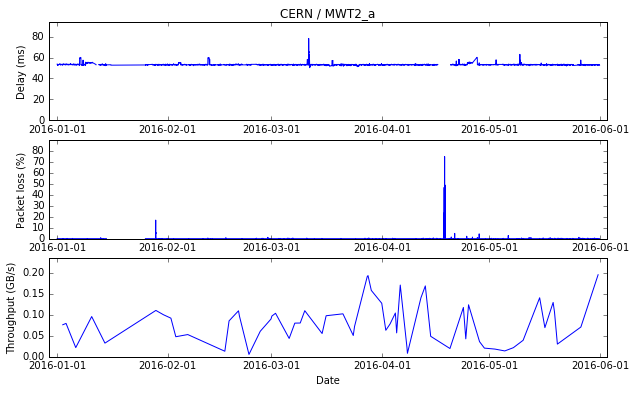

22.  CERN -> MWT2_b


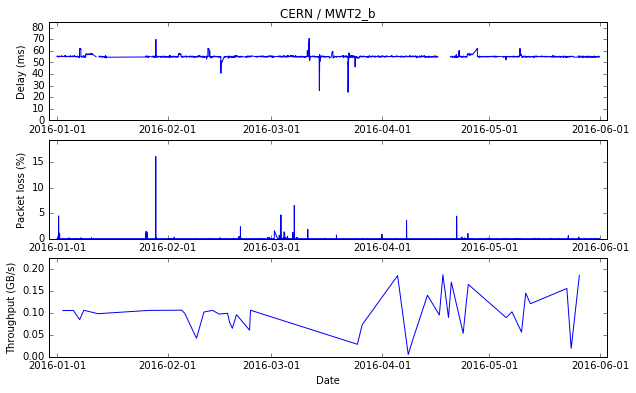

23.  CERN -> MWT2_c


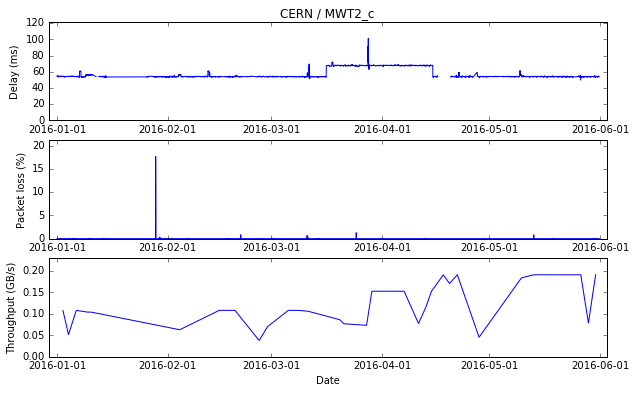

24.  CERN -> SFU


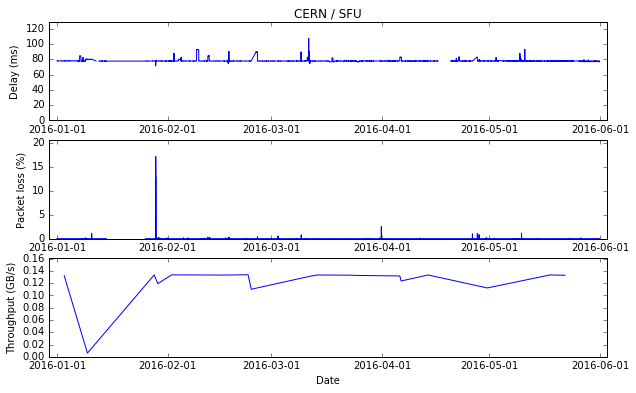

25.  CERN -> BEIJING


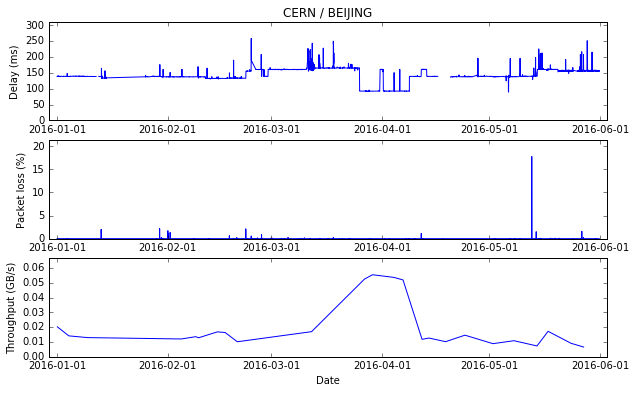

26.  BEIJING -> MWT2_a


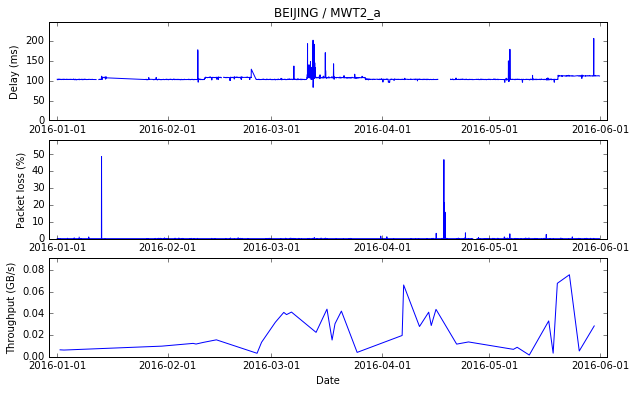

27.  BEIJING -> MWT2_b


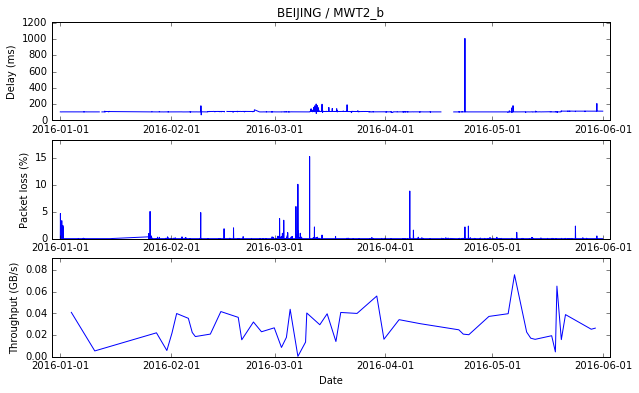

28.  BEIJING -> MWT2_c


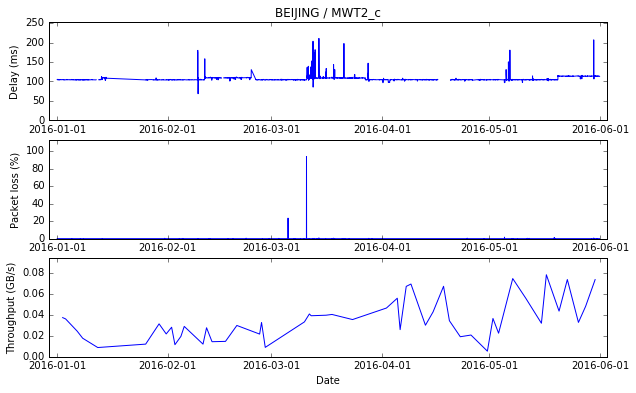

29.  BEIJING -> SFU


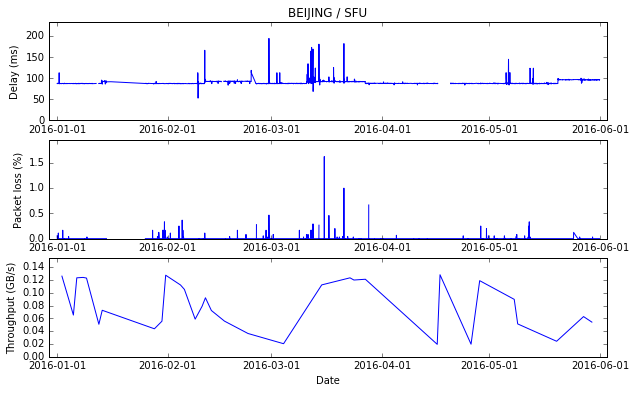

30.  BEIJING -> CERN


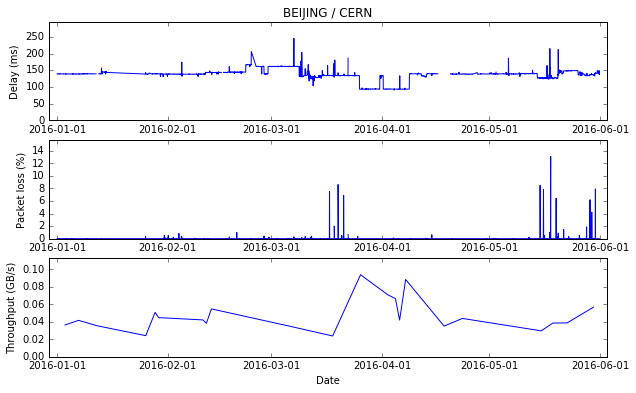

In [88]:
name_list = ['MWT2_a', 'MWT2_b', 'MWT2_c', 'SFU', 'CERN', 'BEIJING']
ip_list_lpl = ['192.170.227.160', '149.165.225.223', '72.36.96.4', '206.12.24.251', '128.142.223.247', '202.122.32.170']
ip_list_t = ['192.170.227.162', '149.165.225.224', '72.36.96.9', '206.12.24.250', '128.142.223.246', '202.122.32.166']

countbig = 0
for src_i in range(6):
    for dest_i in range(6):
        if src_i != dest_i:
            countbig += 1
            print('{}.  {} -> {}'.format(countbig, name_list[src_i], name_list[dest_i]))
            data_lpl = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(ip_list_lpl[src_i], ip_list_lpl[dest_i]))
            data_t = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(ip_list_t[src_i], ip_list_t[dest_i]))
            
            x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
            lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']
            
            time_lpl = data_lpl.index
            dm = data_lpl.delay_median
            pl = data_lpl.packet_loss * 100
            
            time_t = data_t.index
            tp = data_t.throughput / 1024 / 1024 / 1024 / 8
            
#             plt.figure(figsize=[11, 7])
            plt.figure(figsize=[10, 6])
            
            plt.subplot(3, 1, 1)
            plt.plot(time_lpl, dm, label='delay (ms)')
            plt.ylabel('Delay (ms)')
            plt.ylim([0, dm.max() * 1.2])
            plt.xlim([1451400000000, 1464900000000])
            plt.xticks(x, lbl, rotation=0)
            
            plt.title('{} / {}'.format(name_list[src_i], name_list[dest_i]))
            
            plt.subplot(3, 1, 2)
            plt.plot(time_lpl, pl, label='packet loss (%)')
            plt.ylabel('Packet loss (%)')
            plt.ylim([0, pl.max() * 1.2])
            plt.xlim([1451400000000, 1464900000000])
            plt.xticks(x, lbl, rotation=0)
            
            plt.subplot(3, 1, 3)
            plt.plot(time_t, tp, label='throughput (GB/s)')
            plt.ylabel('Throughput (GB/s)')
            plt.ylim([0, tp.max() * 1.2])
            plt.xlim([1451400000000, 1464900000000])
            plt.xticks(x, lbl, rotation=0)
            
            plt.xlabel('Date')
            
            plt.show()
            
#             print()
#             print('Negative delay values: ')
#             count = 0
#             minvalue = 10
#             maxvalue = -99999
#             for value in dm:
#                 if value < 0:
#                     print(value)
#                     count += 1
#                     if value < minvalue:
#                         minvalue = value
#                     if value > maxvalue:
#                         maxvalue = value
#             print('count = {}   minvalue = {}   maxvalue = {}'.format(count, minvalue, maxvalue))
#             print()
#             print('Negative packet loss values: ')
#             count = 0
#             minvalue = 10
#             maxvalue = -99999
#             for value in pl:
#                 if value < 0:
#                     print(value)
#             print()
#             print('Negative throughput values: ')
#             count = 0
#             minvalue = 10
#             maxvalue = -99999
#             for value in tp:
#                 if value < 0:
#                     print(value)
#             print()


# time1 = ''
# dm = ''
# pl = ''

# time2 = ''
# tp = ''

# plt.subplot(3, 1, 1)

# plt.plot(time1, dm, label='delay (ms)')

# plt.subplot(3, 1, 2)

# plt.plot(time1, pl, label='packet loss (%)')

# plt.subplot(3, 1, 3)

# plt.plot(time2, tp, label='throughput (GB/s)')

# plt.show()


In [ ]:
# def norm_delay_and_packet_loss(src_site, dest_site):
#     data = pd.read_pickle('My_data/My_data_from_{}_to_{}_sorted.pkl'.format(src_site, dest_site))

#     dm = data.delay_median
#     tp = data.throughput / 1024 / 1024 / 1024 / 8
#     pl = data.packet_loss

#     plt.figure(figsize=[16, 9])
#     plt.plot(data.index, (dm - np.mean(dm)) / np.std(dm), label='delay (ms)')
#     plt.plot(data.index, (pl - np.mean(pl)) / np.std(pl), label='packet loss (%)')
#     plt.scatter(data.index, (tp - np.mean(tp)) / np.std(tp) * 10 * -1, label='throughput (GB/s)', c='#7fb800', s=30)
#     plt.legend()
#     plt.xlabel('Time (unix time)')
#     plt.title('{} / {}'.format(src_site, dest_site))
#     plt.show()
    
#     d = dm[dm.notnull()]
#     plt.figure(figsize=[10, 9])
#     plt.hist((d-np.mean(d))/np.std(d), 50, facecolor='green', alpha=0.75)
#     plt.show()

1.  MWT2_a -> MWT2_b


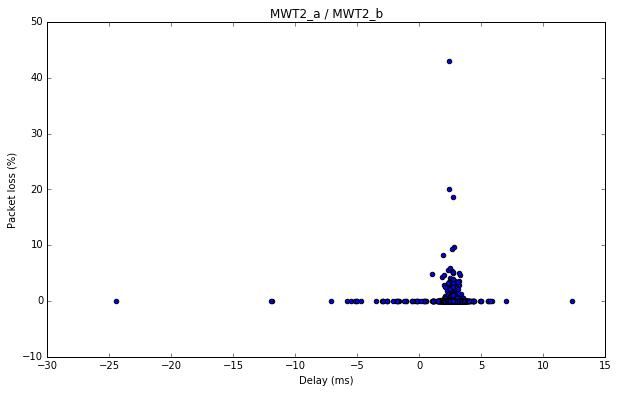

2.  MWT2_a -> MWT2_c


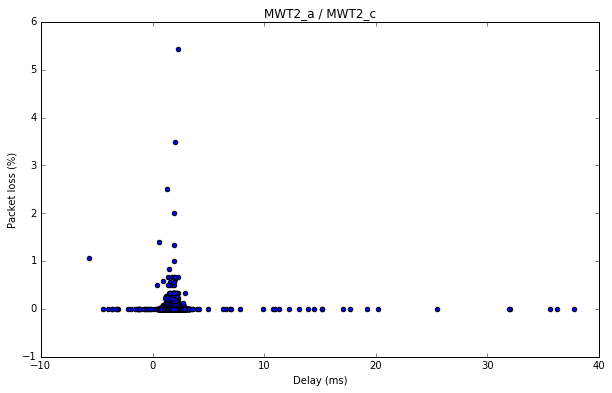

3.  MWT2_a -> SFU


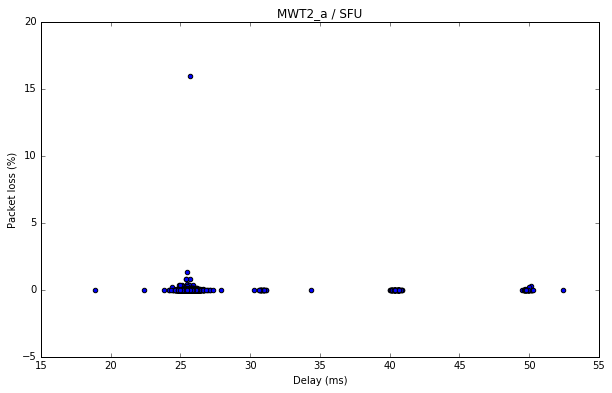

4.  MWT2_a -> CERN


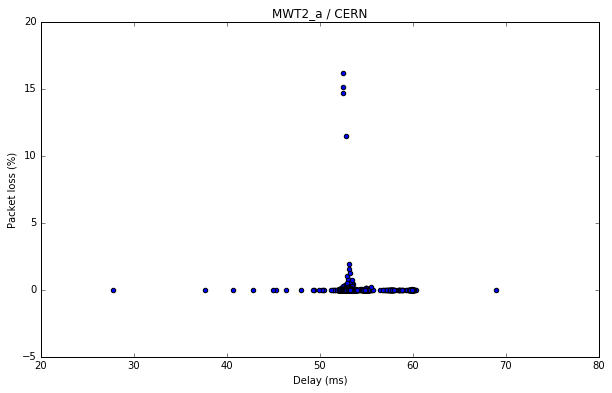

5.  MWT2_a -> BEIJING


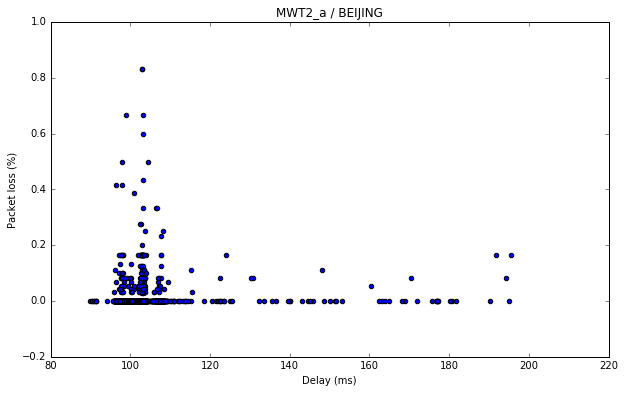

6.  MWT2_b -> MWT2_a


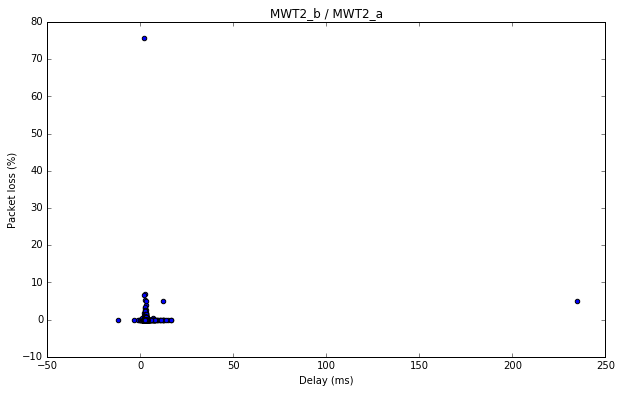

7.  MWT2_b -> MWT2_c


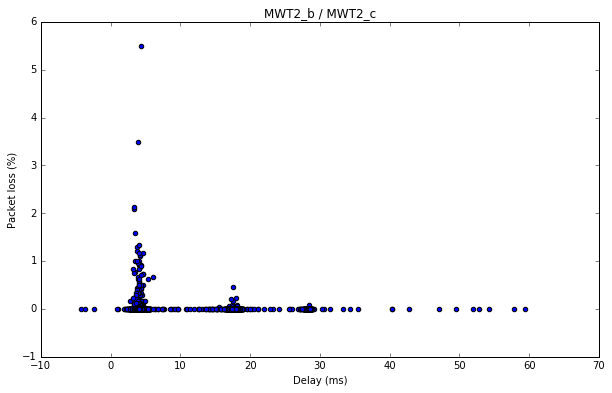

8.  MWT2_b -> SFU


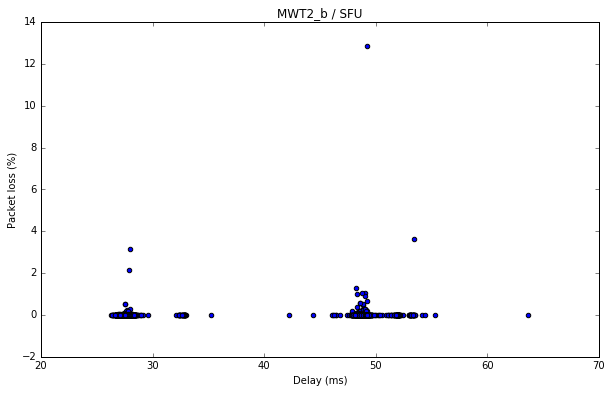

9.  MWT2_b -> CERN


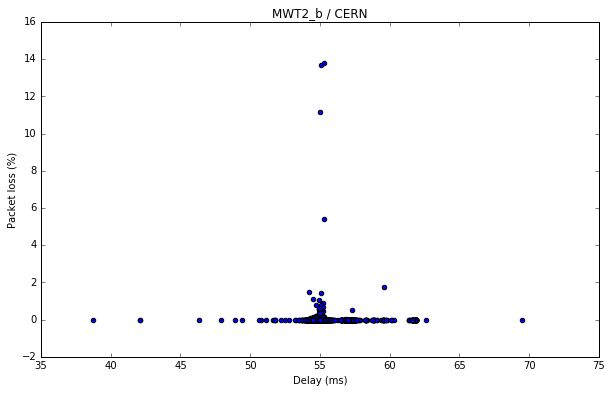

10.  MWT2_b -> BEIJING


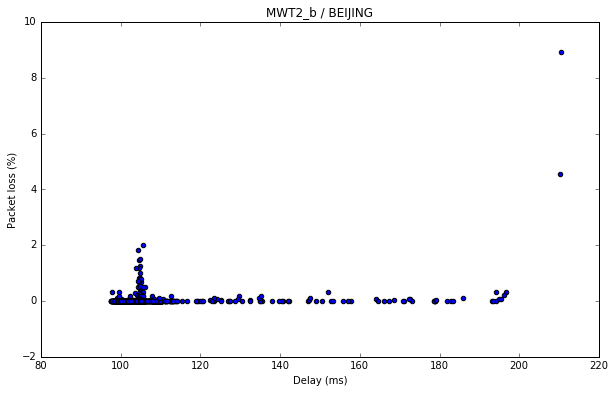

11.  MWT2_c -> MWT2_a


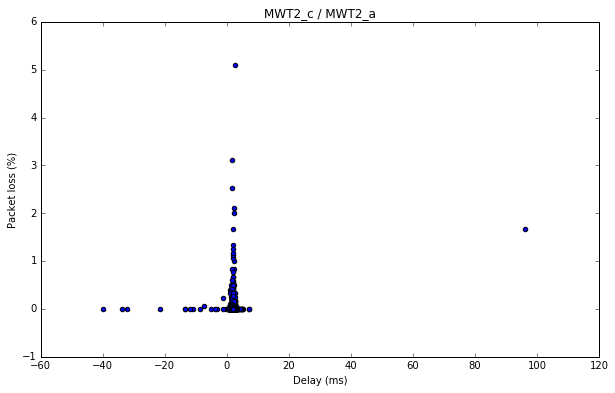

12.  MWT2_c -> MWT2_b


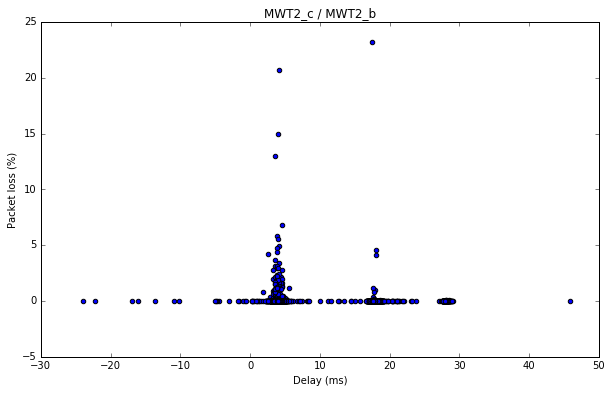

13.  MWT2_c -> SFU


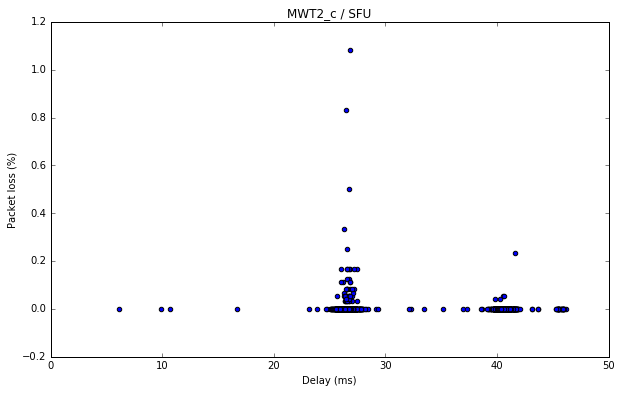

14.  MWT2_c -> CERN


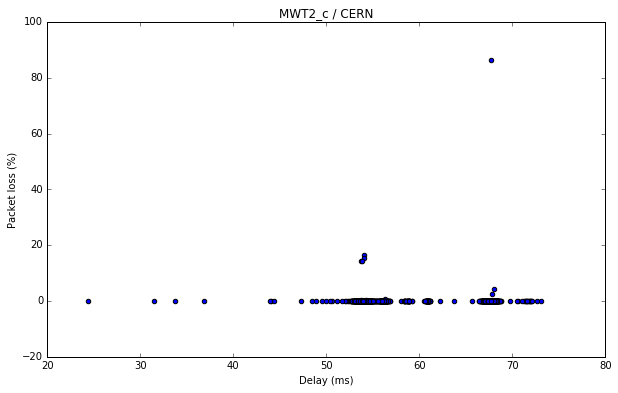

15.  MWT2_c -> BEIJING


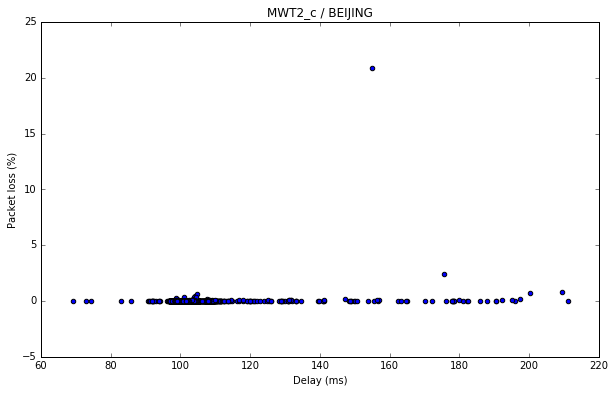

16.  SFU -> MWT2_a


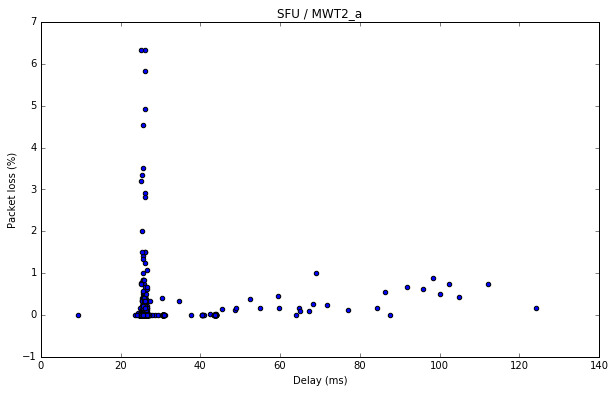

17.  SFU -> MWT2_b


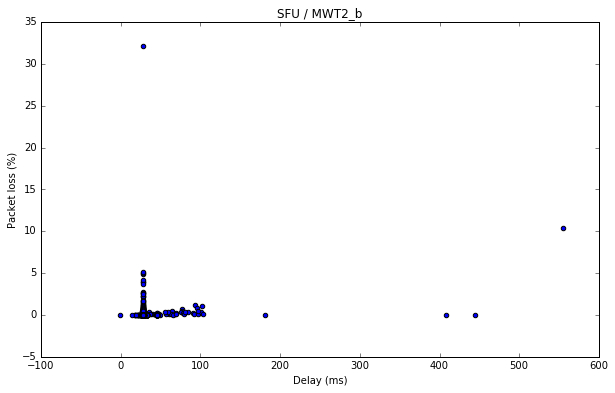

18.  SFU -> MWT2_c


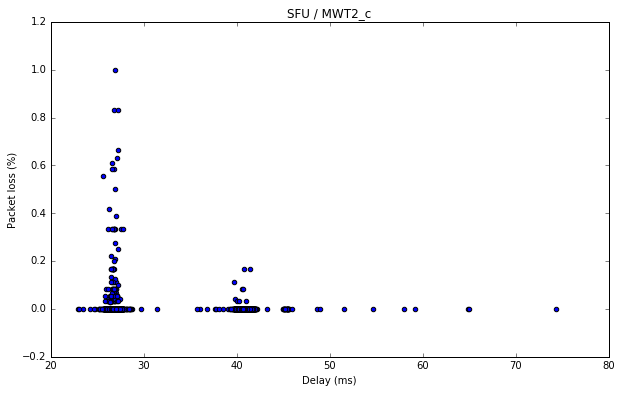

19.  SFU -> CERN


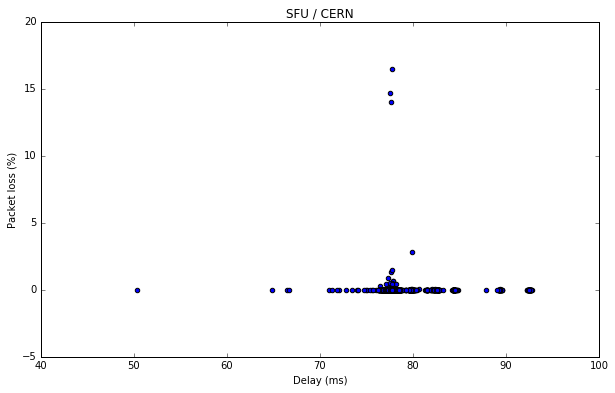

20.  SFU -> BEIJING


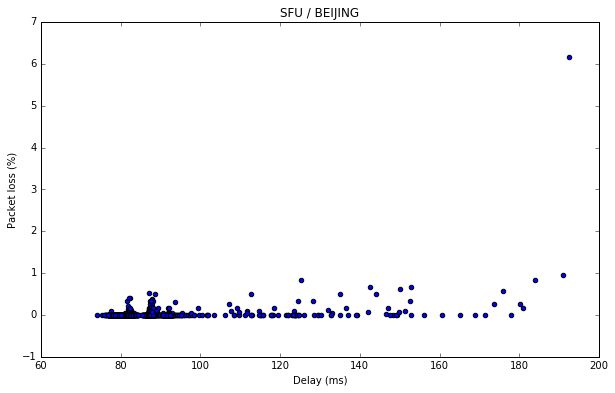

21.  CERN -> MWT2_a


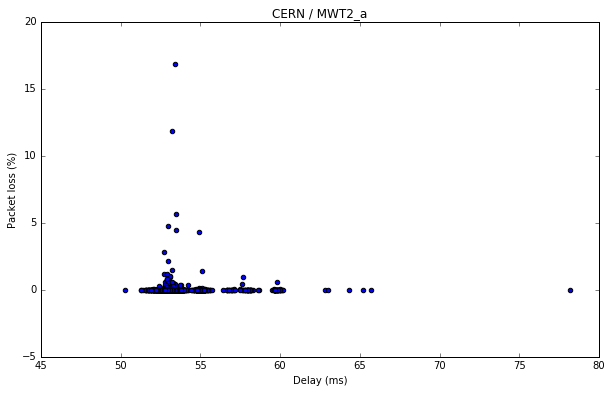

22.  CERN -> MWT2_b


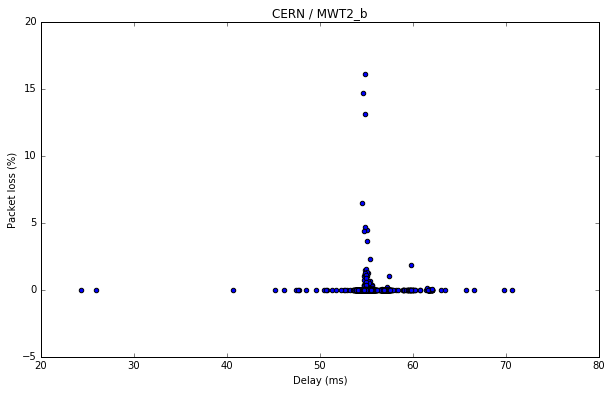

23.  CERN -> MWT2_c


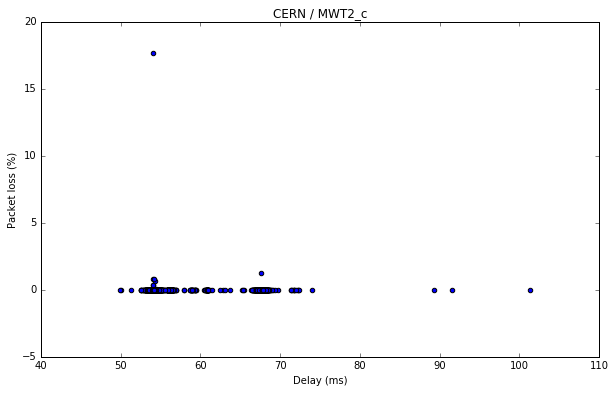

24.  CERN -> SFU


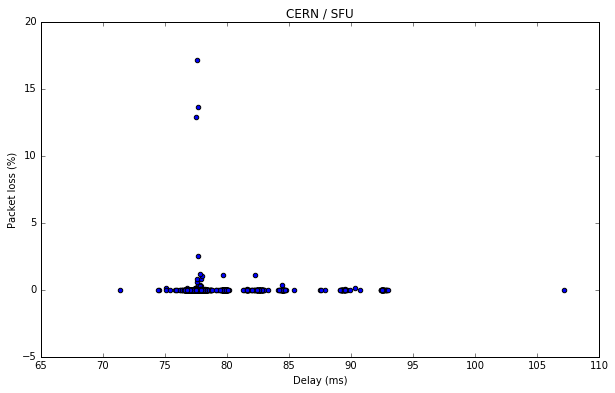

25.  CERN -> BEIJING


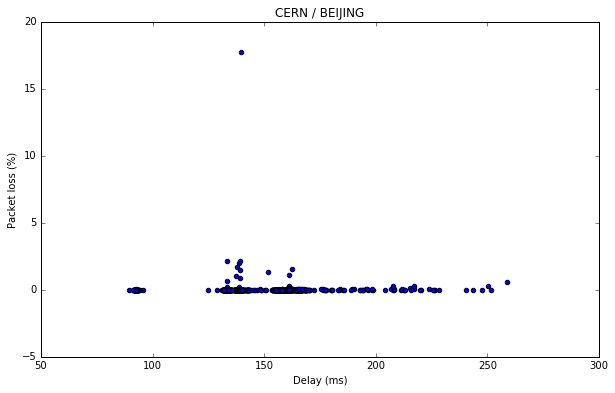

26.  BEIJING -> MWT2_a


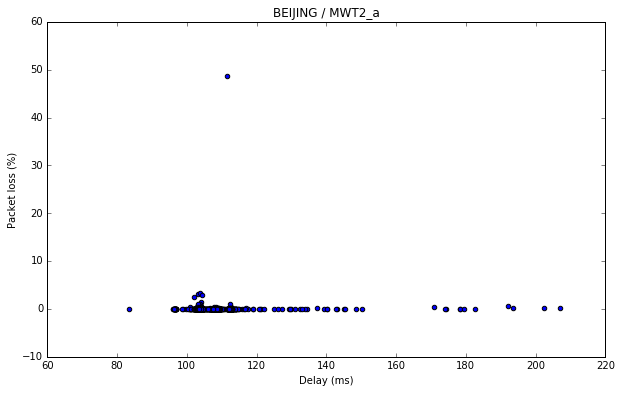

27.  BEIJING -> MWT2_b


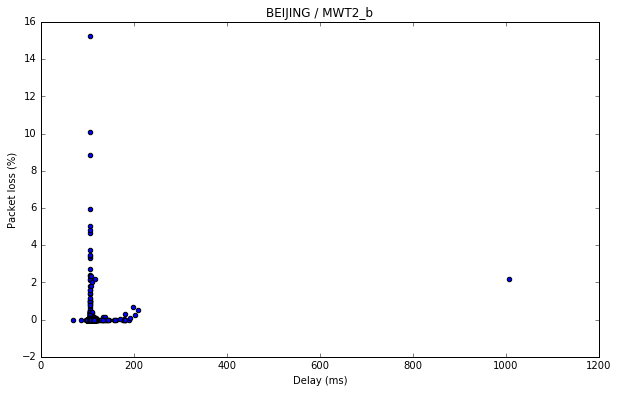

28.  BEIJING -> MWT2_c


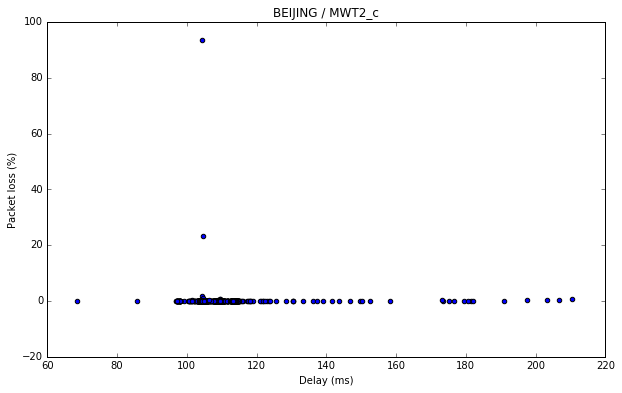

29.  BEIJING -> SFU


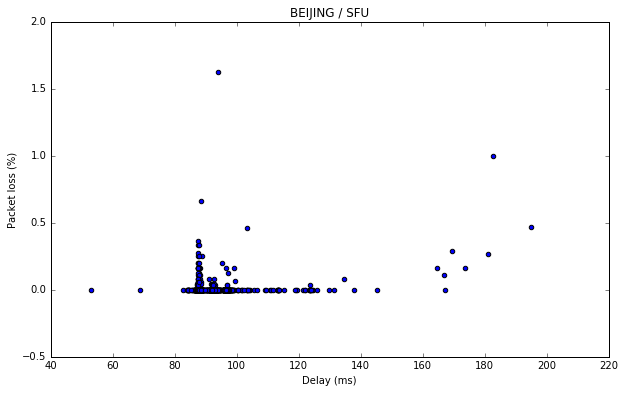

30.  BEIJING -> CERN


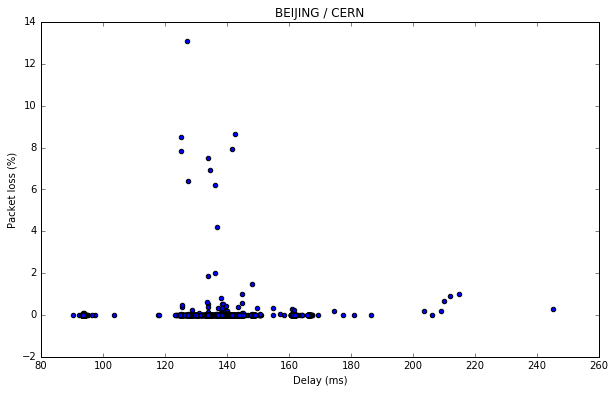

In [90]:
name_list = ['MWT2_a', 'MWT2_b', 'MWT2_c', 'SFU', 'CERN', 'BEIJING']
ip_list_lpl = ['192.170.227.160', '149.165.225.223', '72.36.96.4', '206.12.24.251', '128.142.223.247', '202.122.32.170']
ip_list_t = ['192.170.227.162', '149.165.225.224', '72.36.96.9', '206.12.24.250', '128.142.223.246', '202.122.32.166']

countbig = 0
for src_i in range(6):
    for dest_i in range(6):
        if src_i != dest_i:
            countbig += 1
            print('{}.  {} -> {}'.format(countbig, name_list[src_i], name_list[dest_i]))
            data_lpl = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(ip_list_lpl[src_i], ip_list_lpl[dest_i]))
            data_t = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(ip_list_t[src_i], ip_list_t[dest_i]))
            
#             x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
#             lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']
            
            time_lpl = data_lpl.index
            dm = data_lpl.delay_median
            pl = data_lpl.packet_loss * 100
            
            time_t = data_t.index
            tp = data_t.throughput / 1024 / 1024 / 1024 / 8
            
#             plt.figure(figsize=[11, 7])
            plt.figure(figsize=[10, 6])
    
            plt.scatter(dm, pl)
            plt.xlabel('Delay (ms)')
            plt.ylabel('Packet loss (%)')
            
            plt.title('{} / {}'.format(name_list[src_i], name_list[dest_i]))
            
#             plt.subplot(3, 1, 1)
#             plt.plot(time_lpl, dm, label='delay (ms)')
#             plt.ylabel('Delay (ms)')
#             plt.ylim([0, dm.max() * 1.2])
#             plt.xlim([1451400000000, 1464900000000])
#             plt.xticks(x, lbl, rotation=0)
            
#             plt.title('{} / {}'.format(name_list[src_i], name_list[dest_i]))
            
#             plt.subplot(3, 1, 2)
#             plt.plot(time_lpl, pl, label='packet loss (%)')
#             plt.ylabel('Packet loss (%)')
#             plt.ylim([0, pl.max() * 1.2])
#             plt.xlim([1451400000000, 1464900000000])
#             plt.xticks(x, lbl, rotation=0)
            
#             plt.subplot(3, 1, 3)
#             plt.plot(time_t, tp, label='throughput (GB/s)')
#             plt.ylabel('Throughput (GB/s)')
#             plt.ylim([0, tp.max() * 1.2])
#             plt.xlim([1451400000000, 1464900000000])
#             plt.xticks(x, lbl, rotation=0)
            
#             plt.xlabel('Date')
            
            plt.show()